In [2]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as LA
from scipy import linalg as sLA
import time
from scipy.interpolate import interp1d

d = 2

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append("../scripts")

from state import *

In [5]:
def Hamiltonian(t):
    return 2*np.pi*( X() + Y()*np.sin(8*t))

def L(T2 = 110):
    G = 1/T2
    return np.sqrt(G/2) * Z()
    
def get_list_kraus(dt, T2 = 110):
    gamma = 1 - np.exp(-(2 * dt) / T2)
    E_0 = np.array([[1, 0], 
                    [0, np.sqrt(1 - gamma)]], dtype=complex)
    E_1 = np.array([[0, 0], [0, np.sqrt(gamma)]], dtype=complex)
    return [E_0, E_1]

def commute(A, B):
    return np.dot(A,B) - np.dot(B,A)

def anticommute(A, B):
    return np.dot(A,B) + np.dot(B,A)

def U(t,dt):
    return sLA.expm(-1j*Hamiltonian(t)*dt)

def F(rho1, rho2):
    return np.abs(np.trace(sLA.sqrtm(sLA.sqrtm(rho1) @ rho2 @ sLA.sqrtm(rho1))))**2

    

In [6]:
def unitary_evolution(rho0, dt,t0 = 0, t1 = 0.5):
    t_list = []
    U_list = []
    rho_list = []
    F_list = []

    
    rho = rho0.copy()
    rho_list.append(rho)
    F_list.append(F(rho, rho))
    t_list.append(t0)

    t = t0
    


    while t <= t1:
        U_list.append(U(t,dt))
        t += dt
        print
        rho = np.dot(np.dot(U_list[-1],rho), U_list[-1].conj().T)
        list_kraus = get_list_kraus(dt)
        rho_new = np.zeros((2, 2), dtype=complex)
        for kraus in list_kraus:
            rho_new += kraus @ rho @ kraus.T.conjugate()
        rho = rho_new
        t_list.append(t)
        rho_list.append(rho)
        F_list.append(F(rho, rho0))
        
    return t_list, F_list

def Lindblad_evolution(rho0, dt,t0 = 0, t1 = 0.5):
    t_list = []
    F_list = []
    rho_list = []

#     rho0 = build_rho()

    t = t0
    rho = rho0.copy()


    while t <= t1:
        F_list.append(F(rho, rho0))
        t_list.append(t)
        rho_list.append(rho)
        rho += dt*(-1j*commute(Hamiltonian(t),rho) - \
                   1/2*anticommute(np.dot(np.conjugate(L()).T, L()), rho) + \
                   np.dot(L(), np.dot(rho, np.conjugate(L()).T)))
        t += dt

    return t_list, F_list

In [7]:
np.random.seed(12)

state = Qstate(N = 1)
state.build_pure_random_state()
rho0 = state.get_rho()
state.get_vec(), state.get_rho()

(array([ 0.24793457+0.12708443j, -0.35719682-0.89150907j]),
 array([[ 0.077622  +0.j        , -0.20185836+0.17564177j],
        [-0.20185836-0.17564177j,  0.922378  +0.j        ]]))

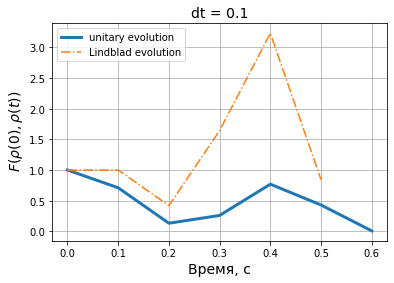

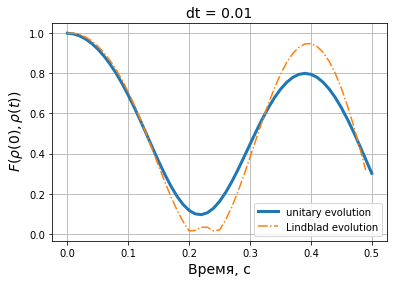

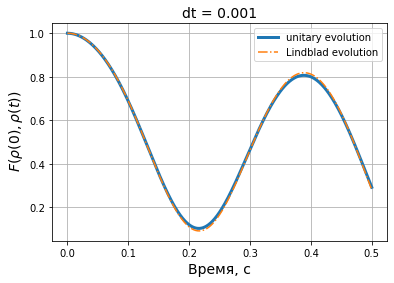

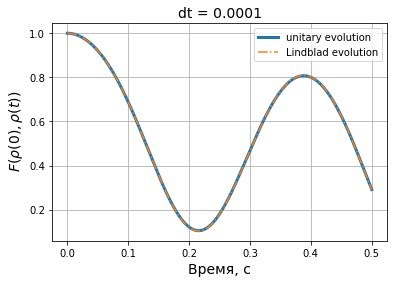

In [8]:
for dt in [0.1, 0.01, 0.001, 0.0001]:
    t_unit, F_unit = unitary_evolution(rho0, dt = dt,t0 = 0, t1 = 0.5)
    t_lindblad, F_lindblad = Lindblad_evolution(rho0, dt = dt,t0 = 0, t1 = 0.5)
    fig, ax = plt.subplots()
    ax.set_title(r'dt = {}'.format(dt), fontsize = 14)
    ax.plot(t_unit, F_unit, label = r'unitary evolution', linewidth = 3)
    ax.plot(t_lindblad, F_lindblad, label = r'Lindblad evolution', linestyle = '-.')
    plt.grid()
    plt.xlabel(r'Время, c', fontsize = 14)
    plt.ylabel(r' $F(\rho(0),\rho(t))$', fontsize = 14)
    plt.legend()
    plt.show()

# 3.2. Генерация случайных чисел

In [9]:
import math
from scipy.integrate import quad

In [10]:
coefs = np.array([0,0,0,1])
theta = np.pi

Генерация полиномов Эрмита:

In [11]:
def hermit(x, n):
    if n == 0:
        return 1
    elif n == 1:
        return 2 * x
    else:
        return 2 * x * hermit(x, n - 1) - 2 * (n - 1) * hermit(x, n - 2)

In [12]:
def hermit_cheb(x, n):
    return (1 / np.sqrt((2 ** n) * math.factorial(n) * np.sqrt(np.pi))) * hermit(x, n) * np.exp(-(x ** 2) / 2)

In [13]:
# функция плотности распределения
def get_density_probability(x, theta):
    amp_probability =  hermit_cheb(x, 2) * np.exp(1j *2* theta)
    return np.abs(amp_probability) ** 2

# функция распределения
def get_func_distr(x, theta):
    prob = quad(lambda x: get_density_probability(x, theta), -100, x)[0]
    return prob

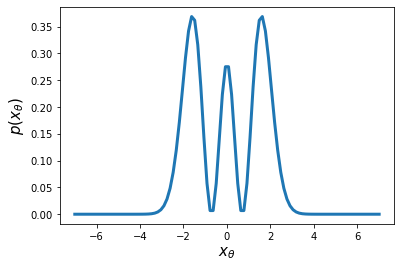

In [14]:
fig, ax = plt.subplots()
x_span = np.linspace(-7, 7, 100)
dens_prob = get_density_probability(x_span, theta)

plt.plot(x_span, dens_prob, lw=3, alpha=1)
ax.minorticks_off()
plt.xlabel(r'$x_{\theta}$', fontsize=15)
plt.ylabel(r'$p(x_{\theta})$', fontsize=15)
plt.show()

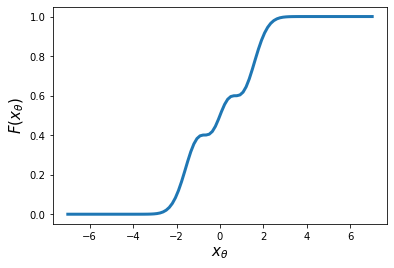

In [15]:
x_span = np.linspace(-7, 7, 100)
func_distr = []
for x in x_span:
    func_distr.append(get_func_distr(x, theta))
func_distr = np.array(func_distr)
fig, ax = plt.subplots()
plt.plot(x_span, func_distr, lw=3, alpha=1)
ax.minorticks_off()
plt.xlabel(r'$x_{\theta}$', fontsize=15)
plt.ylabel(r'$F(x_{\theta})$', fontsize=15)
plt.show()

In [16]:
# Обратная функция
condition = ((func_distr>1e-15) & (func_distr<1-1e-15))
inv_func = interp1d(func_distr[condition], x_span[condition], kind='cubic')

In [17]:
inv_func

In [18]:
k = 10000
sample_x_theta = []
for i in range(k):
    F = np.random.rand()
#     print(F)
    sample_x_theta.append(inv_func(F))
sample_x_theta = np.array(sample_x_theta)

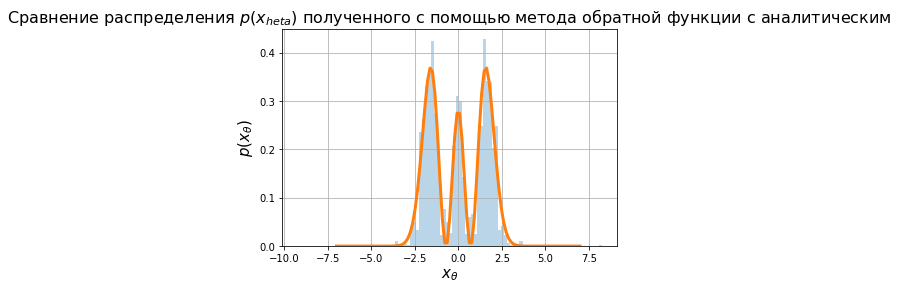

In [19]:
plt.hist(sample_x_theta, bins=100, alpha=0.3, density=True)
plt.plot(x_span, dens_prob, lw=3, alpha=1)
plt.xlabel(r'$x_{\theta}$', fontsize=15)
plt.ylabel(r'$p(x_{\theta})$', fontsize=15)
plt.title('Сравнение распределения $p(x_{\theta})$ полученного с помощью метода обратной функции с аналитическим',
         fontsize = 16)
plt.grid()
plt.show()

Реализуем алгоритм Метрополиса

In [20]:
avg_x_2 = quad(lambda x: (x ** 2) * get_density_probability(x, theta), -100, 100)[0]
avg_x = quad(lambda x: x * get_density_probability(x, theta), -100, 100)[0]
sigma = np.sqrt(avg_x_2 - avg_x ** 2)

In [21]:
# параметр отвечат за разброс по x
d = 3*sigma

In [22]:
N = 10
x_k = np.random.randn(k)
for _ in range(N):
    g = np.random.rand(k) - 0.5
    gamma = np.random.rand(k)
    x_tmp = copy.copy(x_k)
    x_k += d * g
    # print(get_density_probability(x_tmp, theta) < 10 ** (-30))
    index = np.where(get_density_probability(x_k, theta) <= get_density_probability(x_tmp, theta) * gamma)[0]
    x_k[index] = x_tmp[index]
sample_x_theta_metropolis = x_k

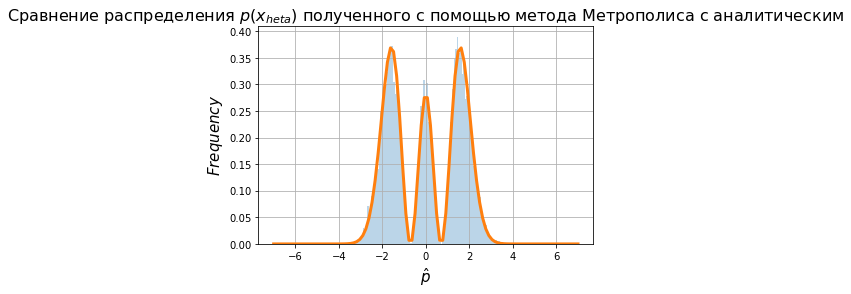

In [23]:
plt.hist(sample_x_theta_metropolis, bins=100, alpha=0.3, density=True)
plt.plot(x_span, dens_prob, lw=3, alpha=1)
plt.xlabel(r'$\hat{p}$', fontsize=15)
plt.ylabel(r'$Frequency$', fontsize=15)
plt.title('Сравнение распределения $p(x_{\theta})$ полученного с помощью метода Метрополиса с аналитическим',
         fontsize = 16)
plt.grid()
plt.show()